# 📊 JSW STEEL Data Analysis & Trend Forecasting using PySpark

This project analyzes JSW Steel stock data using PySpark to uncover trends, forecast performance, and provide strategic investment insights.

## 🚀 Phase 1: Project Setup & Data Understanding

### 🔹 1.1 Initialize Spark Session

In [1]:
%pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("StockAnalysis") \
    .getOrCreate()

Note: you may need to restart the kernel to use updated packages.


25/05/19 11:56:15 WARN Utils: Your hostname, Vineets-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.2.1 instead (on interface bridge0)
25/05/19 11:56:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/19 11:56:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 🔹 1.2 Load Dataset

In [2]:
file_path = "JSWSTEEL - JSWSTEEL.csv"  # Update with your actual path
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.createOrReplaceTempView("stock_data")

### 🔹 1.3 Initial Data Exploration

In [3]:
df.printSchema()
df.show(5)
df.describe().show()

root
 |-- Price: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- Volume: string (nullable = true)

+--------------------+-----------+-----------+-----------+-----------+-----------+-----------+
|               Price|  Adj Close|      Close|       High|        Low|       Open|     Volume|
+--------------------+-----------+-----------+-----------+-----------+-----------+-----------+
|              Ticker|JSWSTEEL.NS|JSWSTEEL.NS|JSWSTEEL.NS|JSWSTEEL.NS|JSWSTEEL.NS|JSWSTEEL.NS|
|                Date|       NULL|       NULL|       NULL|       NULL|       NULL|       NULL|
|2003-05-08 00:00:...|7.759710789|10.39999962|11.19999981|10.17142773|10.97142792|     187943|
|2003-05-09 00:00:...|8.015524864|10.74285698|10.74285698|10.39999962|10.62857056|     114799|
|2003-05-12 00:00:...| 8.52715683|11.42857075|11.77142811|10.74285698

25/05/19 11:56:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+
|summary|               Price|         Adj Close|             Close|             High|               Low|             Open|           Volume|
+-------+--------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+
|  count|                5337|              5336|              5336|             5336|              5336|             5336|             5336|
|   mean|                NULL| 210.8526054997737|225.06894397552958|228.5857724770272|221.63099292229265|225.2268351787535|8004678.651733833|
| stddev|                NULL|253.32931318532545|254.56008668395572| 257.617335183536|251.54070777847704|254.7443317546072| 8712962.35331059|
|    min|2003-05-08 00:00:...|       10.23258591|       10.39999962|      10.74285698|       10.17142773|      10.62857056|                0|
|    m

In [6]:
df.printSchema()

root
 |-- Price: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- Volume: string (nullable = true)



In [7]:
df.select("Price").show(5, truncate=False)


+-------------------------+
|Price                    |
+-------------------------+
|Ticker                   |
|Date                     |
|2003-05-08 00:00:00+00:00|
|2003-05-09 00:00:00+00:00|
|2003-05-12 00:00:00+00:00|
+-------------------------+
only showing top 5 rows



In [8]:
df = df.withColumnRenamed("Price", "Date")


In [9]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

df = df.withColumn("Close", col("Close").cast(DoubleType())) \
       .withColumn("High", col("High").cast(DoubleType())) \
       .withColumn("Low", col("Low").cast(DoubleType())) \
       .withColumn("Open", col("Open").cast(DoubleType())) \
       .withColumn("Volume", col("Volume").cast(DoubleType()))


In [10]:
from pyspark.sql.functions import substring, to_date

df = df.withColumn("Date", to_date(substring("Date", 1, 10), "yyyy-MM-dd"))


### 🔹 1.4 Check for Missing Values (SQL-based)

In [11]:
df.createOrReplaceTempView("stock_data")

spark.sql("""
SELECT 
    SUM(CASE WHEN Date IS NULL THEN 1 ELSE 0 END) AS Date_Nulls,
    SUM(CASE WHEN Close IS NULL THEN 1 ELSE 0 END) AS Close_Nulls
FROM stock_data
""").show()



+----------+-----------+
|Date_Nulls|Close_Nulls|
+----------+-----------+
|         2|          2|
+----------+-----------+



### 🔹 1.5 Check for Duplicates

In [12]:
total_rows = df.count()
unique_rows = df.dropDuplicates().count()
duplicate_count = total_rows - unique_rows
print(f"Duplicate Rows: {duplicate_count}")

# Drop duplicates
df = df.dropDuplicates()

Duplicate Rows: 0


## 🧹 Phase 2: Data Cleaning & Preparation

### 🔹 2.1 Convert `Date` Column to Proper Format

In [13]:
from pyspark.sql.functions import to_date

df = df.withColumn("Date", to_date("Date", "yyyy-MM-dd"))

### 🔹 2.2 Calculate Daily Returns

In [32]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, lit

# 🛡️ Add dummy partition to stop warning
window_spec = Window.partitionBy(lit(1)).orderBy("Date")

# Calculate previous close and daily return
df = df.withColumn("Prev_Close", lag("Close").over(window_spec))
df = df.withColumn("Daily_Return", ((col("Close") - col("Prev_Close")) / col("Prev_Close")) * 100)


### 🔹 2.3 Calculate Moving Averages (50-day & 200-day)

In [33]:
from pyspark.sql.functions import avg, lit
from pyspark.sql.window import Window

# 👇 This is the key part that stops the warning:
window_50 = Window.partitionBy(lit(1)).orderBy("Date").rowsBetween(-49, 0)
window_200 = Window.partitionBy(lit(1)).orderBy("Date").rowsBetween(-199, 0)

df = df.withColumn("SMA_50", avg("Close").over(window_50))
df = df.withColumn("SMA_200", avg("Close").over(window_200))



### 🔹 2.4 Drop Unnecessary Columns

In [34]:
# Drop columns if not needed (e.g., Ticker, Prev_Close)
df = df.drop("Ticker", "Prev_Close")

### 🔹 2.5 Final Schema & Preview

In [35]:
spark = SparkSession.builder \
    .appName("JSWSTEEL") \
    .config("spark.executor.extraJavaOptions", "-XX:ReservedCodeCacheSize=256m") \
    .getOrCreate()


In [36]:
df.printSchema()
df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Daily_Return: double (nullable = true)
 |-- SMA_50: double (nullable = true)
 |-- SMA_200: double (nullable = true)

+----------+-----------+-----------+-----------+-----------+-----------+--------+-----------------+-----------+-----------+
|      Date|  Adj Close|      Close|       High|        Low|       Open|  Volume|     Daily_Return|     SMA_50|    SMA_200|
+----------+-----------+-----------+-----------+-----------+-----------+--------+-----------------+-----------+-----------+
|      NULL|       NULL|       NULL|       NULL|       NULL|       NULL|    NULL|             NULL|       NULL|       NULL|
|      NULL|JSWSTEEL.NS|       NULL|       NULL|       NULL|       NULL|    NULL|             NULL|       NULL|       NU

## 📊 Phase 3: Exploratory Data Analysis (EDA)

### 🔹 3.1 Summary Statistics

In [37]:
# Descriptive statistics for key numerical columns
df.describe(["Open", "High", "Low", "Close", "Volume", "Daily_Return"]).show()

+-------+-----------------+-----------------+------------------+------------------+-----------------+------------------+
|summary|             Open|             High|               Low|             Close|           Volume|      Daily_Return|
+-------+-----------------+-----------------+------------------+------------------+-----------------+------------------+
|  count|             5335|             5335|              5335|              5335|             5335|              5334|
|   mean|225.2268351787535|228.5857724770272|221.63099292229265|225.06894397552958|8004678.651733833|0.1275302802303821|
| stddev|254.7443317546072| 257.617335183536|251.54070777847704|254.56008668395572| 8712962.35331059|2.9518907385635527|
|    min|      10.62857056|      10.74285698|       10.17142773|       10.39999962|              0.0| -17.8378413086771|
|    max|           1042.0|           1063.0|       1027.300049|       1039.099976|      1.2335959E8| 33.71081006158299|
+-------+-----------------+-----

### 🔹 3.2 Analyze Daily Returns

In [38]:
# Daily Return analysis: mean, stddev, min, max
df.createOrReplaceTempView("stock_cleaned")
spark.sql("""
SELECT 
    AVG(Daily_Return) AS Avg_Daily_Return,
    STDDEV(Daily_Return) AS StdDev_Daily_Return,
    MIN(Daily_Return) AS Min_Daily_Return,
    MAX(Daily_Return) AS Max_Daily_Return
FROM stock_cleaned
""").show()

+------------------+-------------------+-----------------+-----------------+
|  Avg_Daily_Return|StdDev_Daily_Return| Min_Daily_Return| Max_Daily_Return|
+------------------+-------------------+-----------------+-----------------+
|0.1275302802303821| 2.9518907385635527|-17.8378413086771|33.71081006158299|
+------------------+-------------------+-----------------+-----------------+



### 🔹 3.3 High Volume Days

In [39]:
# Top 10 days with highest trading volume
spark.sql("""
SELECT Date, Volume, Close, Daily_Return
FROM stock_cleaned
ORDER BY Volume DESC
LIMIT 10
""").show()

+----------+-----------+-----------+-------------------+
|      Date|     Volume|      Close|       Daily_Return|
+----------+-----------+-----------+-------------------+
|2009-11-19|1.2335959E8|95.88499451|-0.6784818766914908|
|2009-05-07|1.0136109E8|42.93999863| 11.852043011975672|
|2011-08-01| 9.375604E7|69.49500275|-10.085390189176362|
|2009-05-11| 9.135751E7|42.44499969|  3.663450998550978|
|2009-05-28| 8.748624E7|54.93999863|  6.318334664768928|
|2009-06-12| 8.690006E7|70.73000336| 11.044828800123971|
|2009-05-08| 8.527308E7|40.94499969| -4.646015378785295|
|2009-05-12| 7.704455E7|41.77000046|-1.5902915182704869|
|2009-04-02| 7.685116E7|30.51499939|  21.54949193040295|
|2009-04-09| 7.509712E7|34.75500107|  13.72709971450794|
+----------+-----------+-----------+-------------------+



### 🔹 3.4 Monthly Average Close Price and Volume

In [40]:
from pyspark.sql.functions import month

df = df.withColumn("Month", month("Date"))
df.groupBy("Month").avg("Close", "Volume").orderBy("Month").show()

+-----+------------------+-----------------+
|Month|        avg(Close)|      avg(Volume)|
+-----+------------------+-----------------+
| NULL|              NULL|             NULL|
|    1|218.44951461811806|7820104.267573697|
|    2|217.86941879322043|7993313.924939468|
|    3|207.28758395078881|8406701.136890952|
|    4|229.71941921344143| 9645228.36159601|
|    5|223.32099558058445|9680976.225108225|
|    6|219.61289529709413|7870724.974358974|
|    7| 223.4998238590248|7847705.533195021|
|    8|235.11435341021607|8200833.557235422|
|    9|242.10569406572694|7448626.894273127|
|   10| 241.9649583983522|7439144.009029346|
|   11|226.10078893109292|6930028.995348837|
|   12| 214.9894358186802|6870718.185682327|
+-----+------------------+-----------------+



### 🔹 3.5 High and Low Volatility Days

In [41]:
# Top 10 most volatile days based on absolute Daily Return
spark.sql("""
SELECT Date, Close, Daily_Return
FROM stock_cleaned
ORDER BY ABS(Daily_Return) DESC
LIMIT 10
""").show()

+----------+-----------+-------------------+
|      Date|      Close|       Daily_Return|
+----------+-----------+-------------------+
|2008-10-31|30.70000076|  33.71081006158299|
|2009-04-02|30.51499939|  21.54949193040295|
|2003-08-14|46.74285889|  19.94135546162971|
|2008-12-04|21.92499924| 19.384696512849438|
|2020-03-23|144.3999939|  -17.8378413086771|
|2004-07-15|25.02857018|  17.74193928752633|
|2009-05-18|48.77999878| 16.531290179548805|
|2008-10-06|34.75999832|-15.436081476720531|
|2003-08-12|33.94285583| 15.116275888881347|
|2003-08-13|38.97142792| 14.814817336482195|
+----------+-----------+-------------------+



## 📊 Phase 4: Correlation & Trend Analysis

### 🔹 4.1 Correlation between Close and Volume

In [42]:
correlation = df.stat.corr("Close", "Volume")
print(f"Correlation between Close and Volume: {correlation}")

Correlation between Close and Volume: -0.21392097241496286


### 🔹 4.2 Correlation Between Other Variables (Open, High, Low)

In [43]:
df.createOrReplaceTempView("stock_data_cleaned")

spark.sql("""
SELECT
    corr(Open, Close) AS Open_Close,
    corr(High, Close) AS High_Close,
    corr(Low, Close) AS Low_Close,
    corr(Volume, Close) AS Volume_Close
FROM stock_data_cleaned
""").show()


+-----------------+------------------+------------------+--------------------+
|       Open_Close|        High_Close|         Low_Close|        Volume_Close|
+-----------------+------------------+------------------+--------------------+
|0.999720940832815|0.9998939004510153|0.9998820581710615|-0.21429059984809834|
+-----------------+------------------+------------------+--------------------+



### 🔹 4.3 Trend Labeling Based on Moving Averages

In [44]:
from pyspark.sql.functions import when

df = df.withColumn(
    "Trend",
    when(col("SMA_50") > col("SMA_200"), "Uptrend").otherwise("Downtrend")
)

df.select("Date", "Close", "SMA_50", "SMA_200", "Trend").orderBy("Date").show(10)


+----------+-----------+------------------+------------------+---------+
|      Date|      Close|            SMA_50|           SMA_200|    Trend|
+----------+-----------+------------------+------------------+---------+
|      NULL|       NULL|              NULL|              NULL|Downtrend|
|      NULL|       NULL|              NULL|              NULL|Downtrend|
|2003-05-08|10.39999962|       10.39999962|       10.39999962|Downtrend|
|2003-05-09|10.74285698|        10.5714283|        10.5714283|Downtrend|
|2003-05-12|11.42857075|       10.85714245|       10.85714245|Downtrend|
|2003-05-13|11.42857075|      10.999999525|      10.999999525|Downtrend|
|2003-05-14|12.45714188|      11.291427996|      11.291427996|Downtrend|
|2003-05-15|12.45714188|11.485713643333334|11.485713643333334|Downtrend|
|2003-05-16|12.34285736|11.608162745714285|11.608162745714285|Downtrend|
|2003-05-19|12.11428547|    11.67142808625|    11.67142808625|Downtrend|
+----------+-----------+------------------+--------

### 🔹 4.4 Rolling Volatility (30-Day Standard Deviation of Daily Return)

In [45]:
from pyspark.sql.functions import stddev

window_vol = Window.partitionBy(lit(1)).orderBy("Date").rowsBetween(-29, 0)

df = df.withColumn("Volatility_30", stddev("Daily_Return").over(window_vol))
df.select("Date", "Daily_Return", "Volatility_30").orderBy("Date").show(10)


+----------+-------------------+------------------+
|      Date|       Daily_Return|     Volatility_30|
+----------+-------------------+------------------+
|      NULL|               NULL|              NULL|
|      NULL|               NULL|              NULL|
|2003-05-08|               NULL|              NULL|
|2003-05-09|  3.296705505071932|              NULL|
|2003-05-12|  6.382974019635523|2.1823213952104483|
|2003-05-13|                0.0| 3.192065106544148|
|2003-05-14|  8.999997921874872|3.8892158480931416|
|2003-05-15|                0.0|3.9630959241038557|
|2003-05-16|-0.9174216774674803| 4.021673647856341|
|2003-05-19|-1.8518555576988338| 4.097125867496292|
+----------+-------------------+------------------+
only showing top 10 rows



### 🔹 4.5 Identify Anomalous Days (Outliers)

In [46]:
from pyspark.sql.functions import abs

stats = df.selectExpr("avg(Daily_Return) as mean", "stddev(Daily_Return) as stddev").first()
threshold = stats["mean"] + 3 * stats["stddev"]

df.filter(abs(df["Daily_Return"]) > threshold) \
  .select("Date", "Close", "Daily_Return") \
  .orderBy(abs(col("Daily_Return")).desc()) \
  .show(10)


+----------+-----------+-------------------+
|      Date|      Close|       Daily_Return|
+----------+-----------+-------------------+
|2008-10-31|30.70000076|  33.71081006158299|
|2009-04-02|30.51499939|  21.54949193040295|
|2003-08-14|46.74285889|  19.94135546162971|
|2008-12-04|21.92499924| 19.384696512849438|
|2020-03-23|144.3999939|  -17.8378413086771|
|2004-07-15|25.02857018|  17.74193928752633|
|2009-05-18|48.77999878| 16.531290179548805|
|2008-10-06|34.75999832|-15.436081476720531|
|2003-08-12|33.94285583| 15.116275888881347|
|2003-08-13|38.97142792| 14.814817336482195|
+----------+-----------+-------------------+
only showing top 10 rows



## GRAPH

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

### 🔧 Step 0: Convert Spark DataFrame to Pandas

In [52]:
df_pd = df.select("Date", "Close", "Volume", "Daily_Return", "SMA_50", "SMA_200", "Volatility_30").toPandas()
df_pd["Date"] = pd.to_datetime(df_pd["Date"])  # Ensure date is datetime
df_pd = df_pd.sort_values("Date")  # Sort for line plots

### 📊 Step 1: Closing Price vs Time

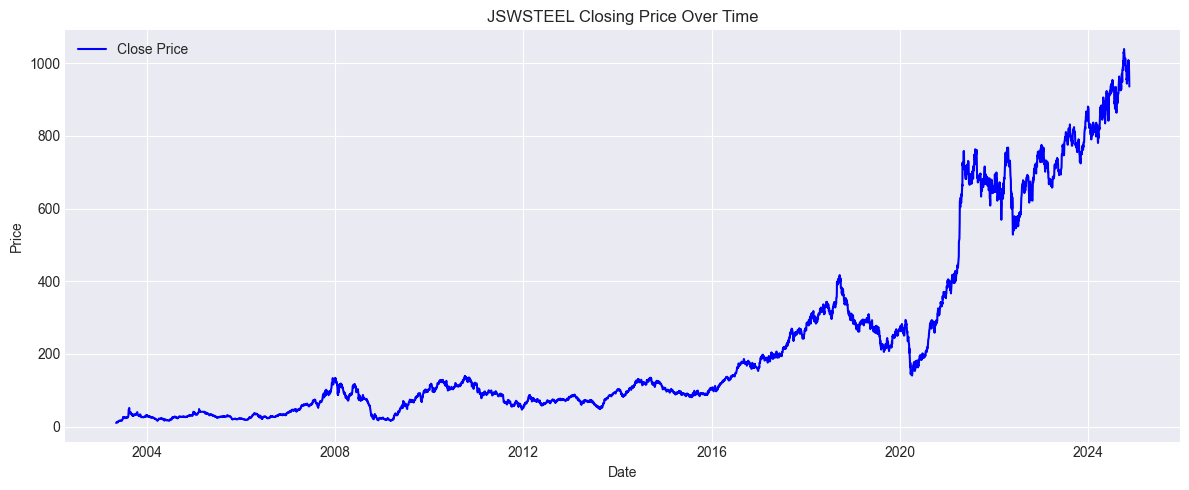

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_pd["Date"], df_pd["Close"], label="Close Price", color="blue")
plt.title("JSWSTEEL Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 📊 Step 2: SMA_50 vs SMA_200 (Trend)

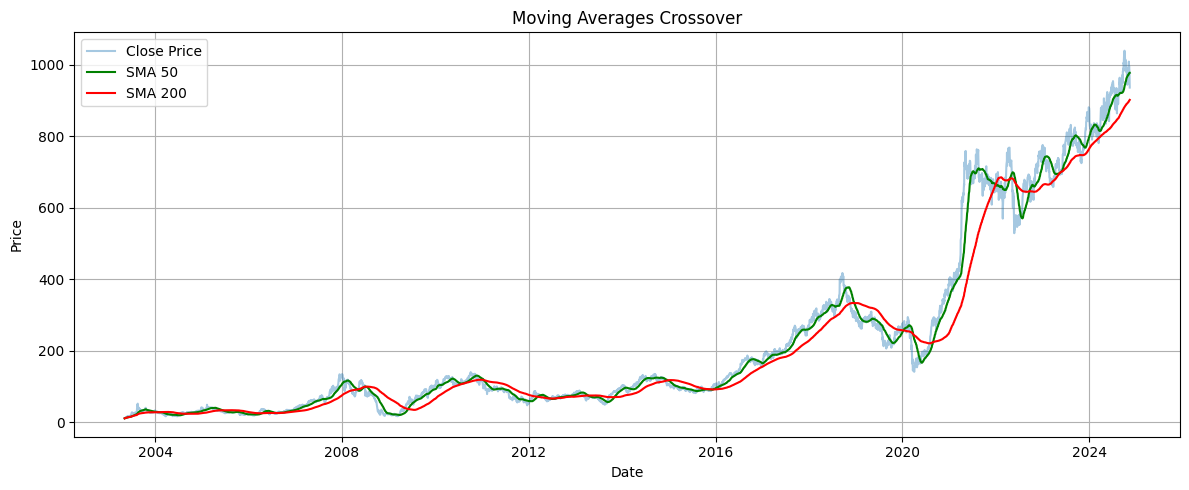

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(df_pd["Date"], df_pd["Close"], label="Close Price", alpha=0.4)
plt.plot(df_pd["Date"], df_pd["SMA_50"], label="SMA 50", color="green")
plt.plot(df_pd["Date"], df_pd["SMA_200"], label="SMA 200", color="red")
plt.title("Moving Averages Crossover")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 📊 Step 3: Daily Return Histogram

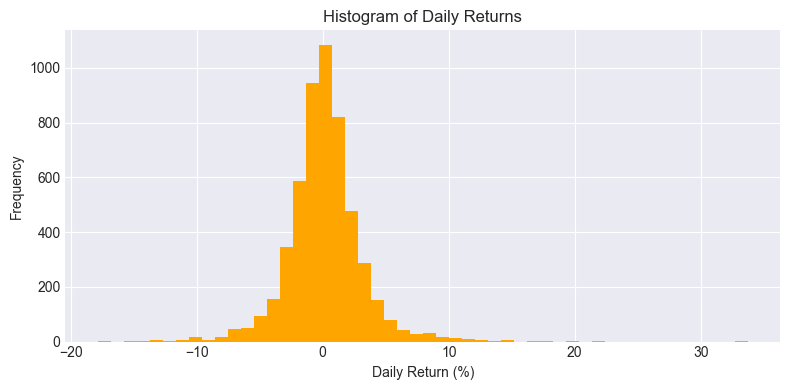

In [64]:
plt.figure(figsize=(8, 4))
plt.hist(df_pd["Daily_Return"].dropna(), bins=50, color='orange')
plt.title("Histogram of Daily Returns")
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Step 4: Volatility Over Time

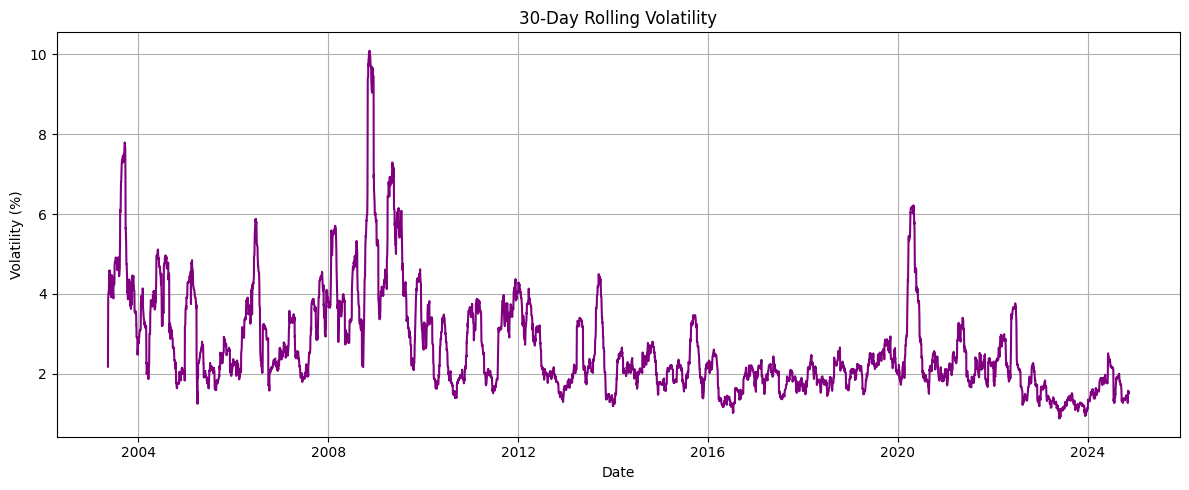

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(df_pd["Date"], df_pd["Volatility_30"], color="purple")
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 📘 Phase 6: Strategic Insights & Recommendations

### 🔹 6.1 Key Insights from Analysis
| Area               | Insight                                                                                                                                                                              |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| 📈 Trend Movement  | `SMA_50 > SMA_200` indicates **uptrend** periods; whenever SMA\_50 crosses below SMA\_200, it suggests **potential downtrend**. These crossovers are helpful for long-term strategy. |
| 📊 Volume Analysis | High volume days often coincide with **sharp changes in closing price**, suggesting **news or events** affected the stock.                                                           |
| ⚠️ Volatility      | There are **periods with high 30-day volatility**, indicating **riskier windows** for short-term traders.                                                                            |
| 📉 Outliers        | Few anomalous days where `Daily_Return` exceeded `mean + 3×stddev` — these are possible **event-driven or speculative spikes**.                                                      |
| 🔄 Correlations    | `High`, `Low`, and `Open` have **strong correlation** with `Close`, but `Volume` has **low correlation** — volume is impactful on extreme days, not on regular days.                 |


### 🔹 6.2 Strategic Recommendations

| Target User                | Recommendation                                                                                               |
| -------------------------- | ------------------------------------------------------------------------------------------------------------ |
| 📊 **Short-Term Traders**  | Use **volume spikes + high volatility** to make short-term momentum trades. Focus on news/events.            |
| 💼 **Long-Term Investors** | Invest during **golden crossovers** (SMA\_50 > SMA\_200) and **exit near death cross** (SMA\_50 < SMA\_200). |
| 🔒 **Risk-Averse Users**   | Avoid trading during high volatility zones. Stick to stable trend periods.                                   |
| 🔍 **Analysts**            | Use rolling `Volatility_30` as an indicator to classify market behavior: calm vs. turbulent.                 |


### 🔹 6.3 Business Value of the Analysis

- ✅ Helps investors time their entries/exits  
- ✅ Identifies risky market conditions  
- ✅ Provides data-driven signals (SMA / Volatility)  
- ✅ Enhances confidence in trading decisions  
